<a href="https://colab.research.google.com/github/ketsiamm/byuids-portfolio/blob/main/notebooks/starter_bikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')

bikes.dtypes

,0
dteday,object
hr,float64
casual,int64
registered,int64
temp_c,float64
feels_like_c,float64
hum,float64
windspeed,float64
weathersit,int64
season,int64


ValueError: Could not interpret value `y` for `y`. An entry with this name does not appear in `data`.

In [ ]:
#hours usage per user

sns.

In [ ]:
sns.

In [ ]:
bikes.hr.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

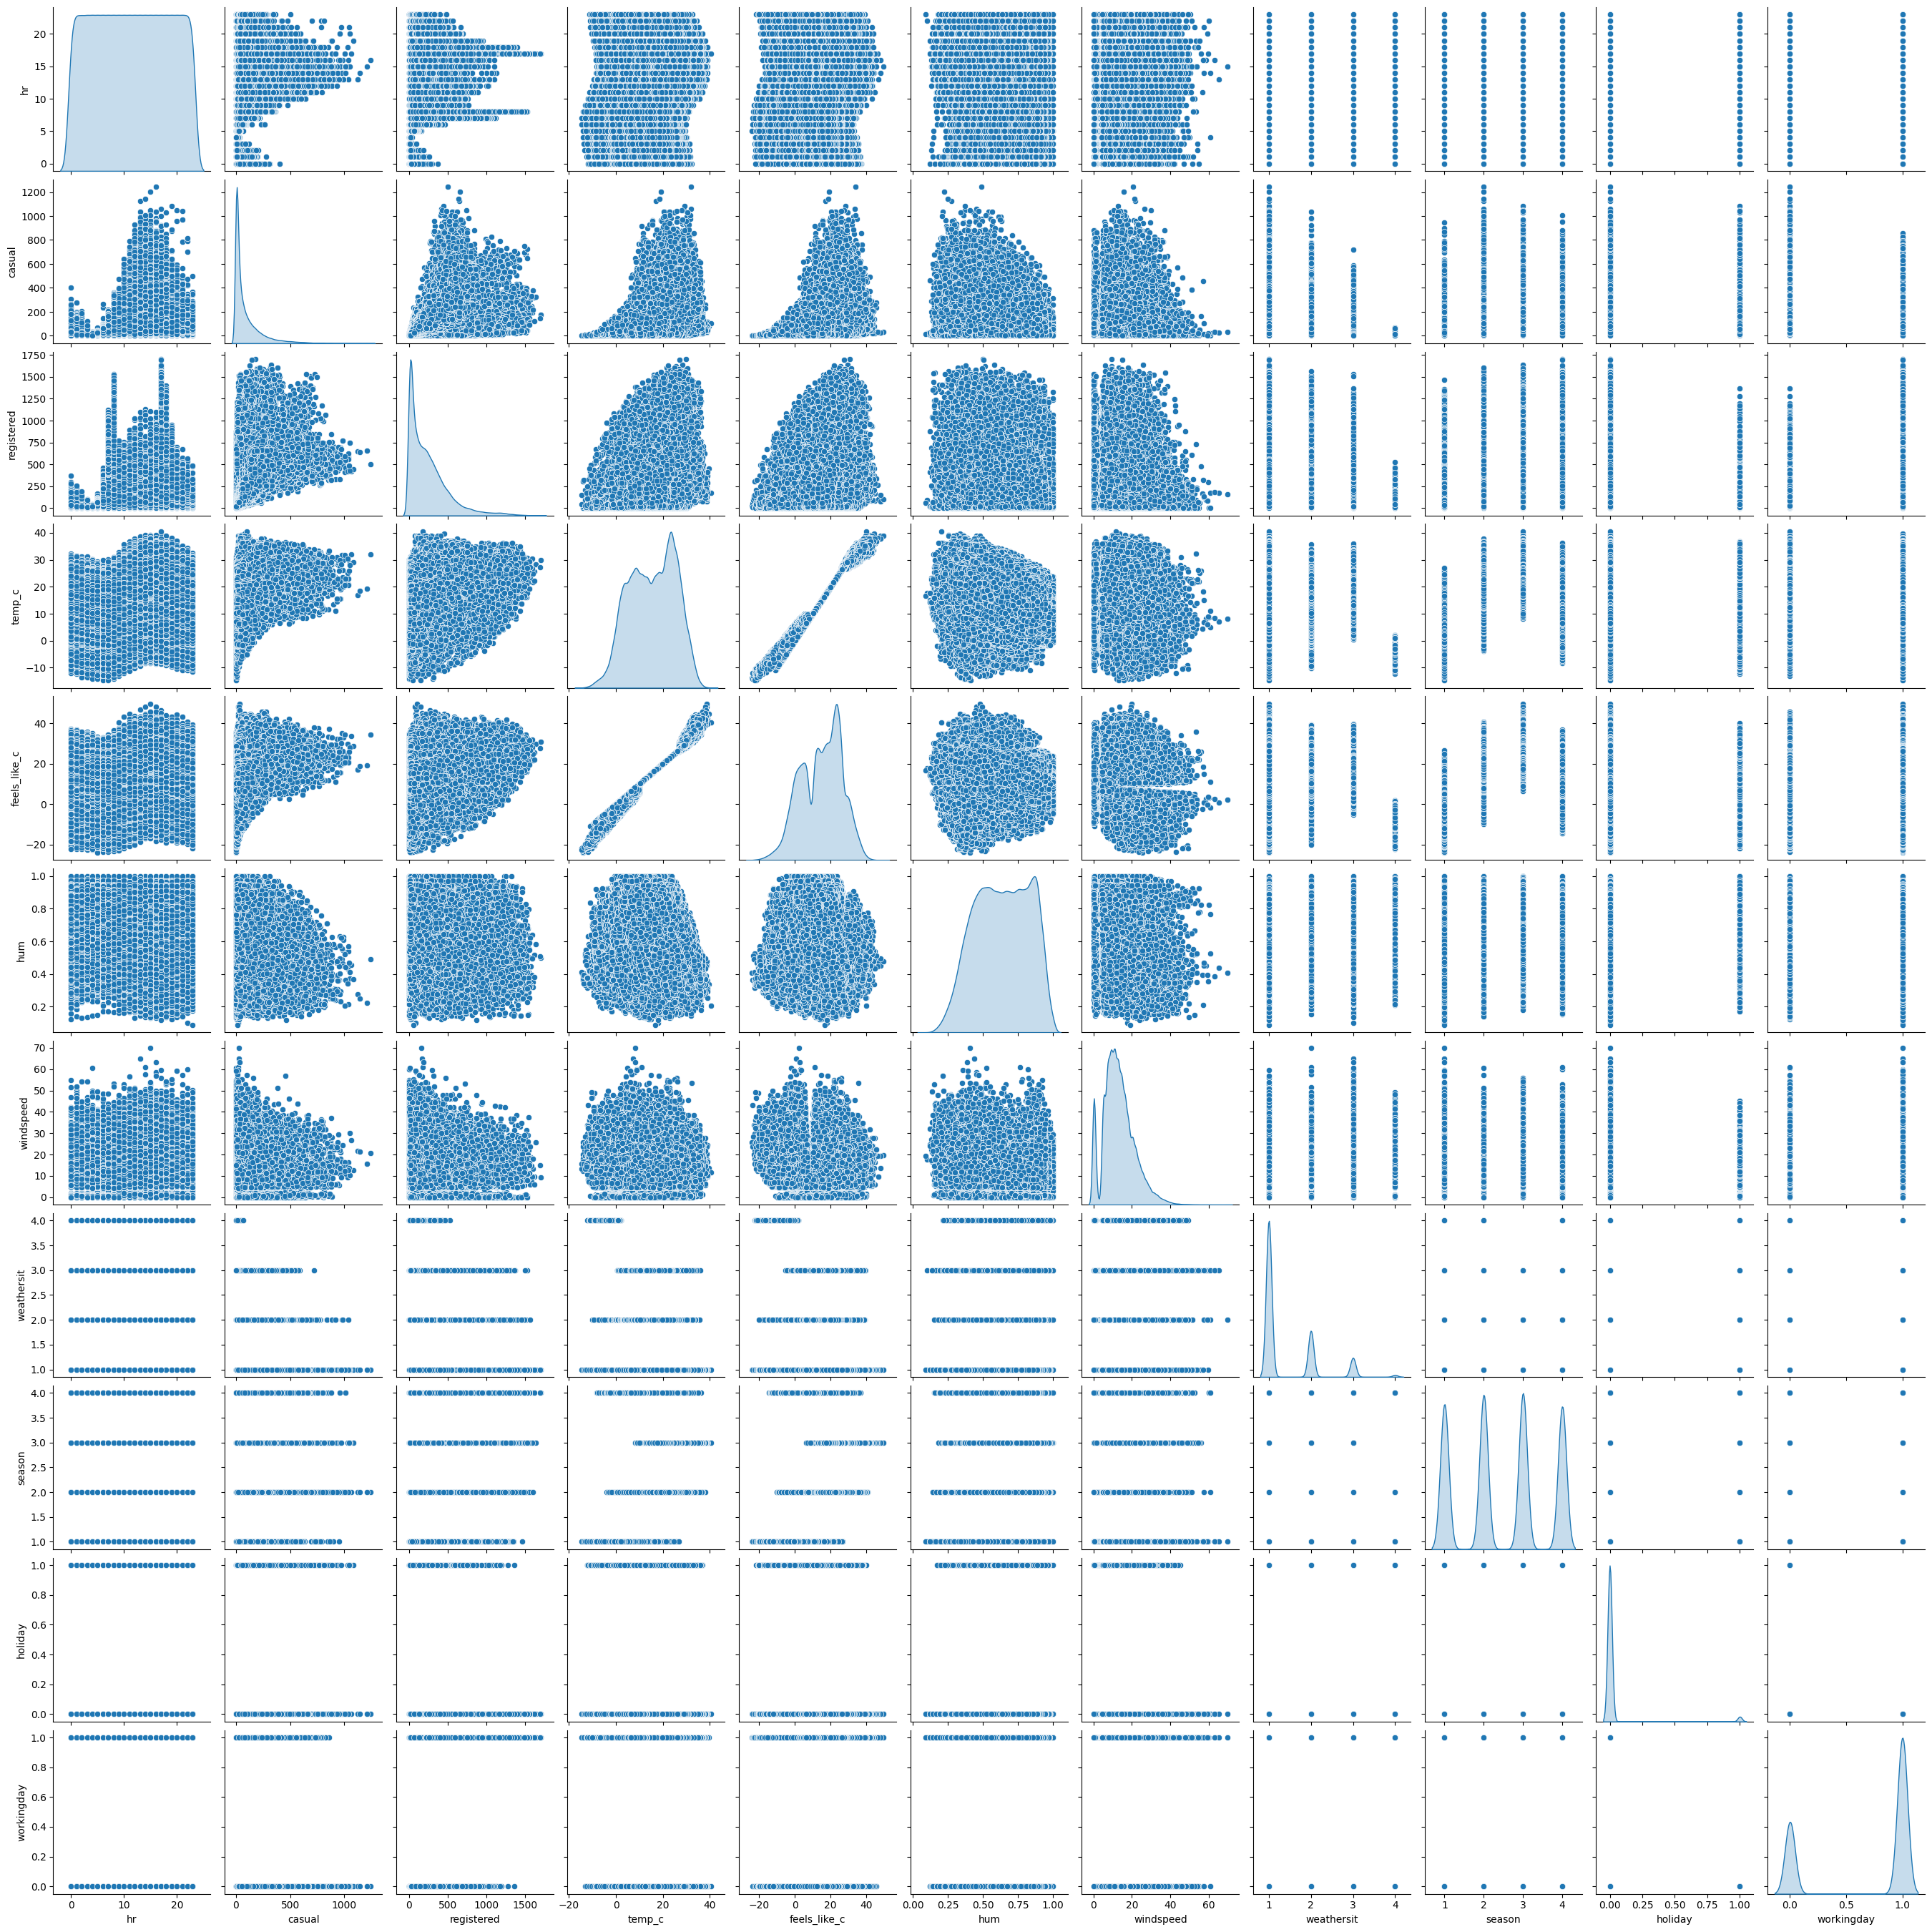

In [ ]:
import seaborn as sns
sns.pairplot(data=bikes, diag_kind='kde')

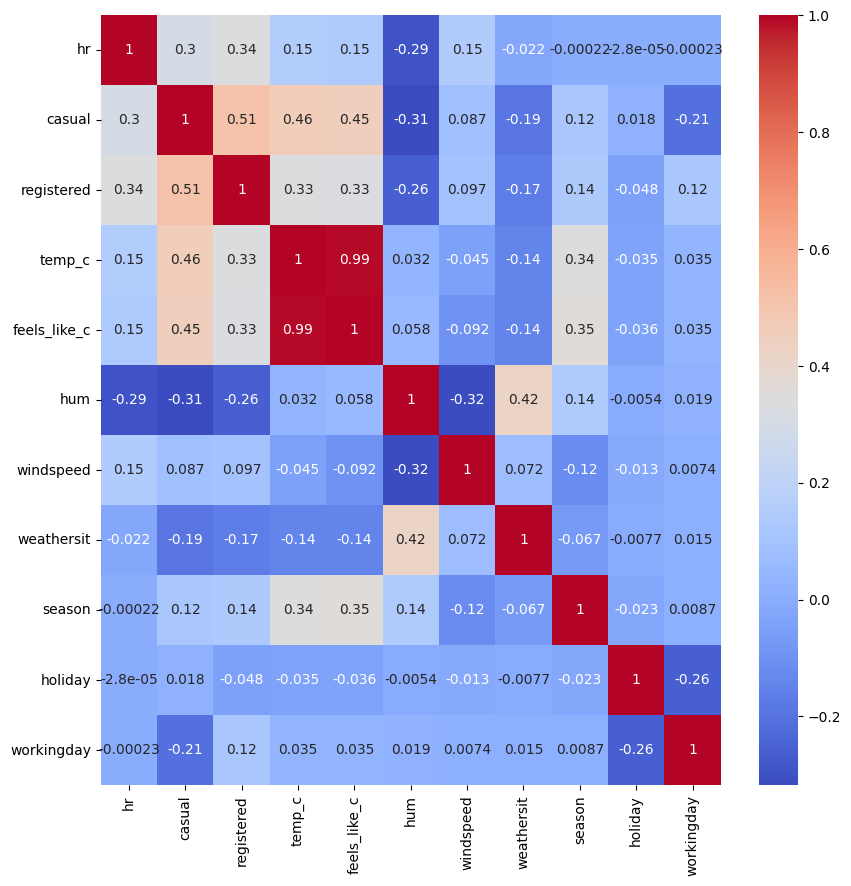

In [ ]:
import matplotlib.pyplot as plt


# Convert 'dteday' column to datetime objects
bikes['dteday'] = pd.to_datetime(bikes['dteday'])

# Extract numerical features for correlation calculation
numerical_features = bikes.select_dtypes(include=['number'])

plt.figure(figsize=(10, 10))
sns.heatmap(numerical_features.corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
seasonal = bikes[[]]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2531/2531 - 9s - 4ms/step - loss: 0.0114 - mae: 0.0751 - mse: 0.0114 - val_loss: 0.0090 - val_mae: 0.0659 - val_mse: 0.0090
Epoch 2/50
2531/2531 - 6s - 2ms/step - loss: 0.0088 - mae: 0.0626 - mse: 0.0088 - val_loss: 0.0082 - val_mae: 0.0610 - val_mse: 0.0082
Epoch 3/50
2531/2531 - 6s - 2ms/step - loss: 0.0078 - mae: 0.0588 - mse: 0.0078 - val_loss: 0.0070 - val_mae: 0.0551 - val_mse: 0.0070
Epoch 4/50
2531/2531 - 7s - 3ms/step - loss: 0.0069 - mae: 0.0555 - mse: 0.0069 - val_loss: 0.0063 - val_mae: 0.0526 - val_mse: 0.0063
Epoch 5/50
2531/2531 - 6s - 2ms/step - loss: 0.0064 - mae: 0.0538 - mse: 0.0064 - val_loss: 0.0060 - val_mae: 0.0514 - val_mse: 0.0060
Epoch 6/50
2531/2531 - 11s - 4ms/step - loss: 0.0062 - mae: 0.0528 - mse: 0.0062 - val_loss: 0.0058 - val_mae: 0.0504 - val_mse: 0.0058
Epoch 7/50
2531/2531 - 10s - 4ms/step - loss: 0.0060 - mae: 0.0521 - mse: 0.0060 - val_loss: 0.0058 - val_mae: 0.0521 - val_mse: 0.0058
Epoch 8/50
2531/2531 - 10s - 4ms/step - loss: 0.0059 

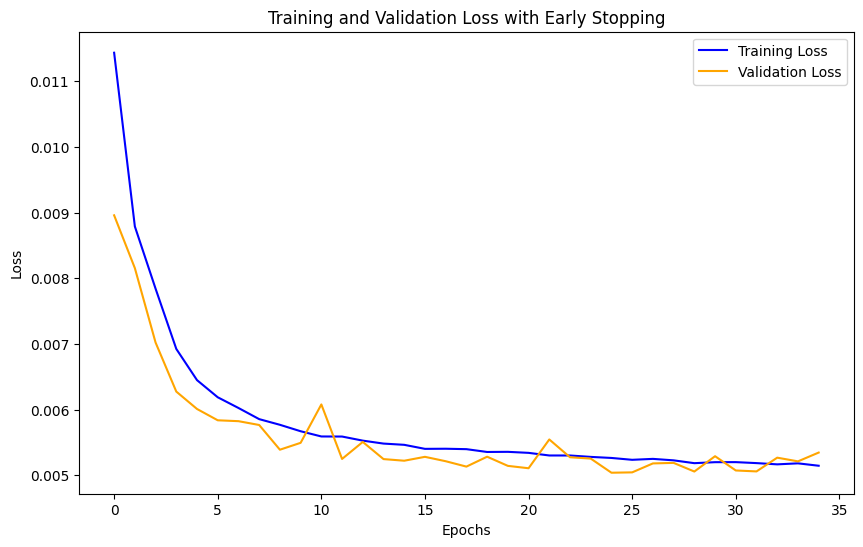

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load and preprocess data
X = bikes.drop(columns=['casual', 'registered', 'dteday'])
y = bikes['casual'] + bikes['registered']  # Target variable

categorical_features = ['season', 'weathersit', 'holiday', 'workingday']
numeric_features = ['temp_c', 'feels_like_c', 'hum', 'windspeed', 'hr']

# Preprocessing: StandardScaler for numerical, OneHotEncoder for categorical
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

X = preprocessor.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Model with Hyperparameter Tuning
def build_model(hp):
    model = keras.Sequential()

    # Input layer with tunable units
    model.add(Dense(units=hp.Int('units_input', min_value=16, max_value=128, step=16),
                    activation='relu',
                    input_shape=(X_train.shape[1],)))

    # Hidden layers with tunable number of layers & units
    for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=16),
                        activation='relu'))

        # Add dropout with a tunable rate
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1))

    # Compile model with tunable learning rate
    model.compile(optimizer=Adam(
                      hp.Choice('learning_rate', values=[0.001, 0.0001, 0.00001])),
                  loss='mse',
                  metrics=['mse', 'mae'])

    return model

# Hyperparameter tuning with Hyperband
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,  # Maximum number of epochs per trial
    factor=3,       # Reduction factor for Hyperband
    directory='tuning_dir',
    project_name='bike_sharing_hyperband'
)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform Hyperparameter Search
tuner.search(X_train, y_train, validation_split=0.1, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=2)

# Retrieve best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate model
test_loss, test_mse, test_mae = best_model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")

# Make predictions
predictions = best_model.predict(X_test)

# Calculate R² score on the test set
r2 = r2_score(y_test, predictions)
print(f"Test R²: {r2}")

# Plot Training vs Validation Loss
history = best_model.history.history
train_loss = history['loss']
val_loss = history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss with Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
